# Performing QSO Classification using Variational Autoencoders¶

This notebook performs Quasar Classification using Variational Autoencoders. The framework used for this deep learning model is Pytorch.


## Authors

* Ash Karale
    

## Contents:

1. Importing Modules
2. Data Acquisition
3. Data Processing
4. Model Definition
5. Model Training


## Versions:

Initial Version: November 2022 (Ash Karale)


### 1. Importing Modules

In [1]:
# Importing all required modules

# system modules 
import os
import sys
import importlib
import pickle
import argparse
import itertools
import csv
from tqdm import tqdm
import time

# data manipulation
import math
import numpy as np
import pandas as pd

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import palettable
import seaborn as sns
from bokeh.io import output_notebook, show
from bokeh.plotting import figure, output_file, show
# pd.set_option('display.max_columns', 1000)

# sklearn
from sklearn import model_selection, preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, normalized_mutual_info_score, adjusted_rand_score

# scipy
from scipy import stats
from scipy.optimize import linear_sum_assignment as linear_assignment

# astropy
from astropy.io import fits
from astropy.table import Table

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader,TensorDataset
from torch.autograd import Variable

print(sys.version)

3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:48:25) 
[Clang 14.0.6 ]


### 2. Data Acquisition

In [2]:
# Route to the path where the dataset is saved locally
data_dir = '/Users/ash/Research/Data/DELVE/'

# Examining the data directory
display(data_dir)

'/Users/ash/Research/Data/DELVE/'

Reading in the data file

In [3]:
from astropy.table import Table
# concatenate the route to data path and point to the specific file
data = Table.read(os.path.join(data_dir, 'fullcat15_30.fits'))
# convert the .fits format to a pandas dataframe for easier manipulation
fc15_30 = data.to_pandas()

Inspecting the attributes

In [4]:
# Inspect all attributes of the chosen dataset
fc15_30.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8226904 entries, 0 to 8226903
Data columns (total 40 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   quick_object_id               int64  
 1   mag_auto_g                    float64
 2   magerr_auto_g                 float64
 3   mag_auto_i                    float64
 4   magerr_auto_i                 float64
 5   mag_auto_r                    float64
 6   magerr_auto_r                 float64
 7   mag_auto_z                    float64
 8   magerr_auto_z                 float64
 9   sourceid_vhs                  int64  
 10  ypetromag                     float64
 11  ypetromagerr                  float64
 12  jpetromag                     float64
 13  jpetromagerr                  float64
 14  hpetromag                     float64
 15  hpetromagerr                  float64
 16  kspetromag                    float64
 17  kspetromagerr                 float64
 18  source_id_catwise     

Visualizing the data

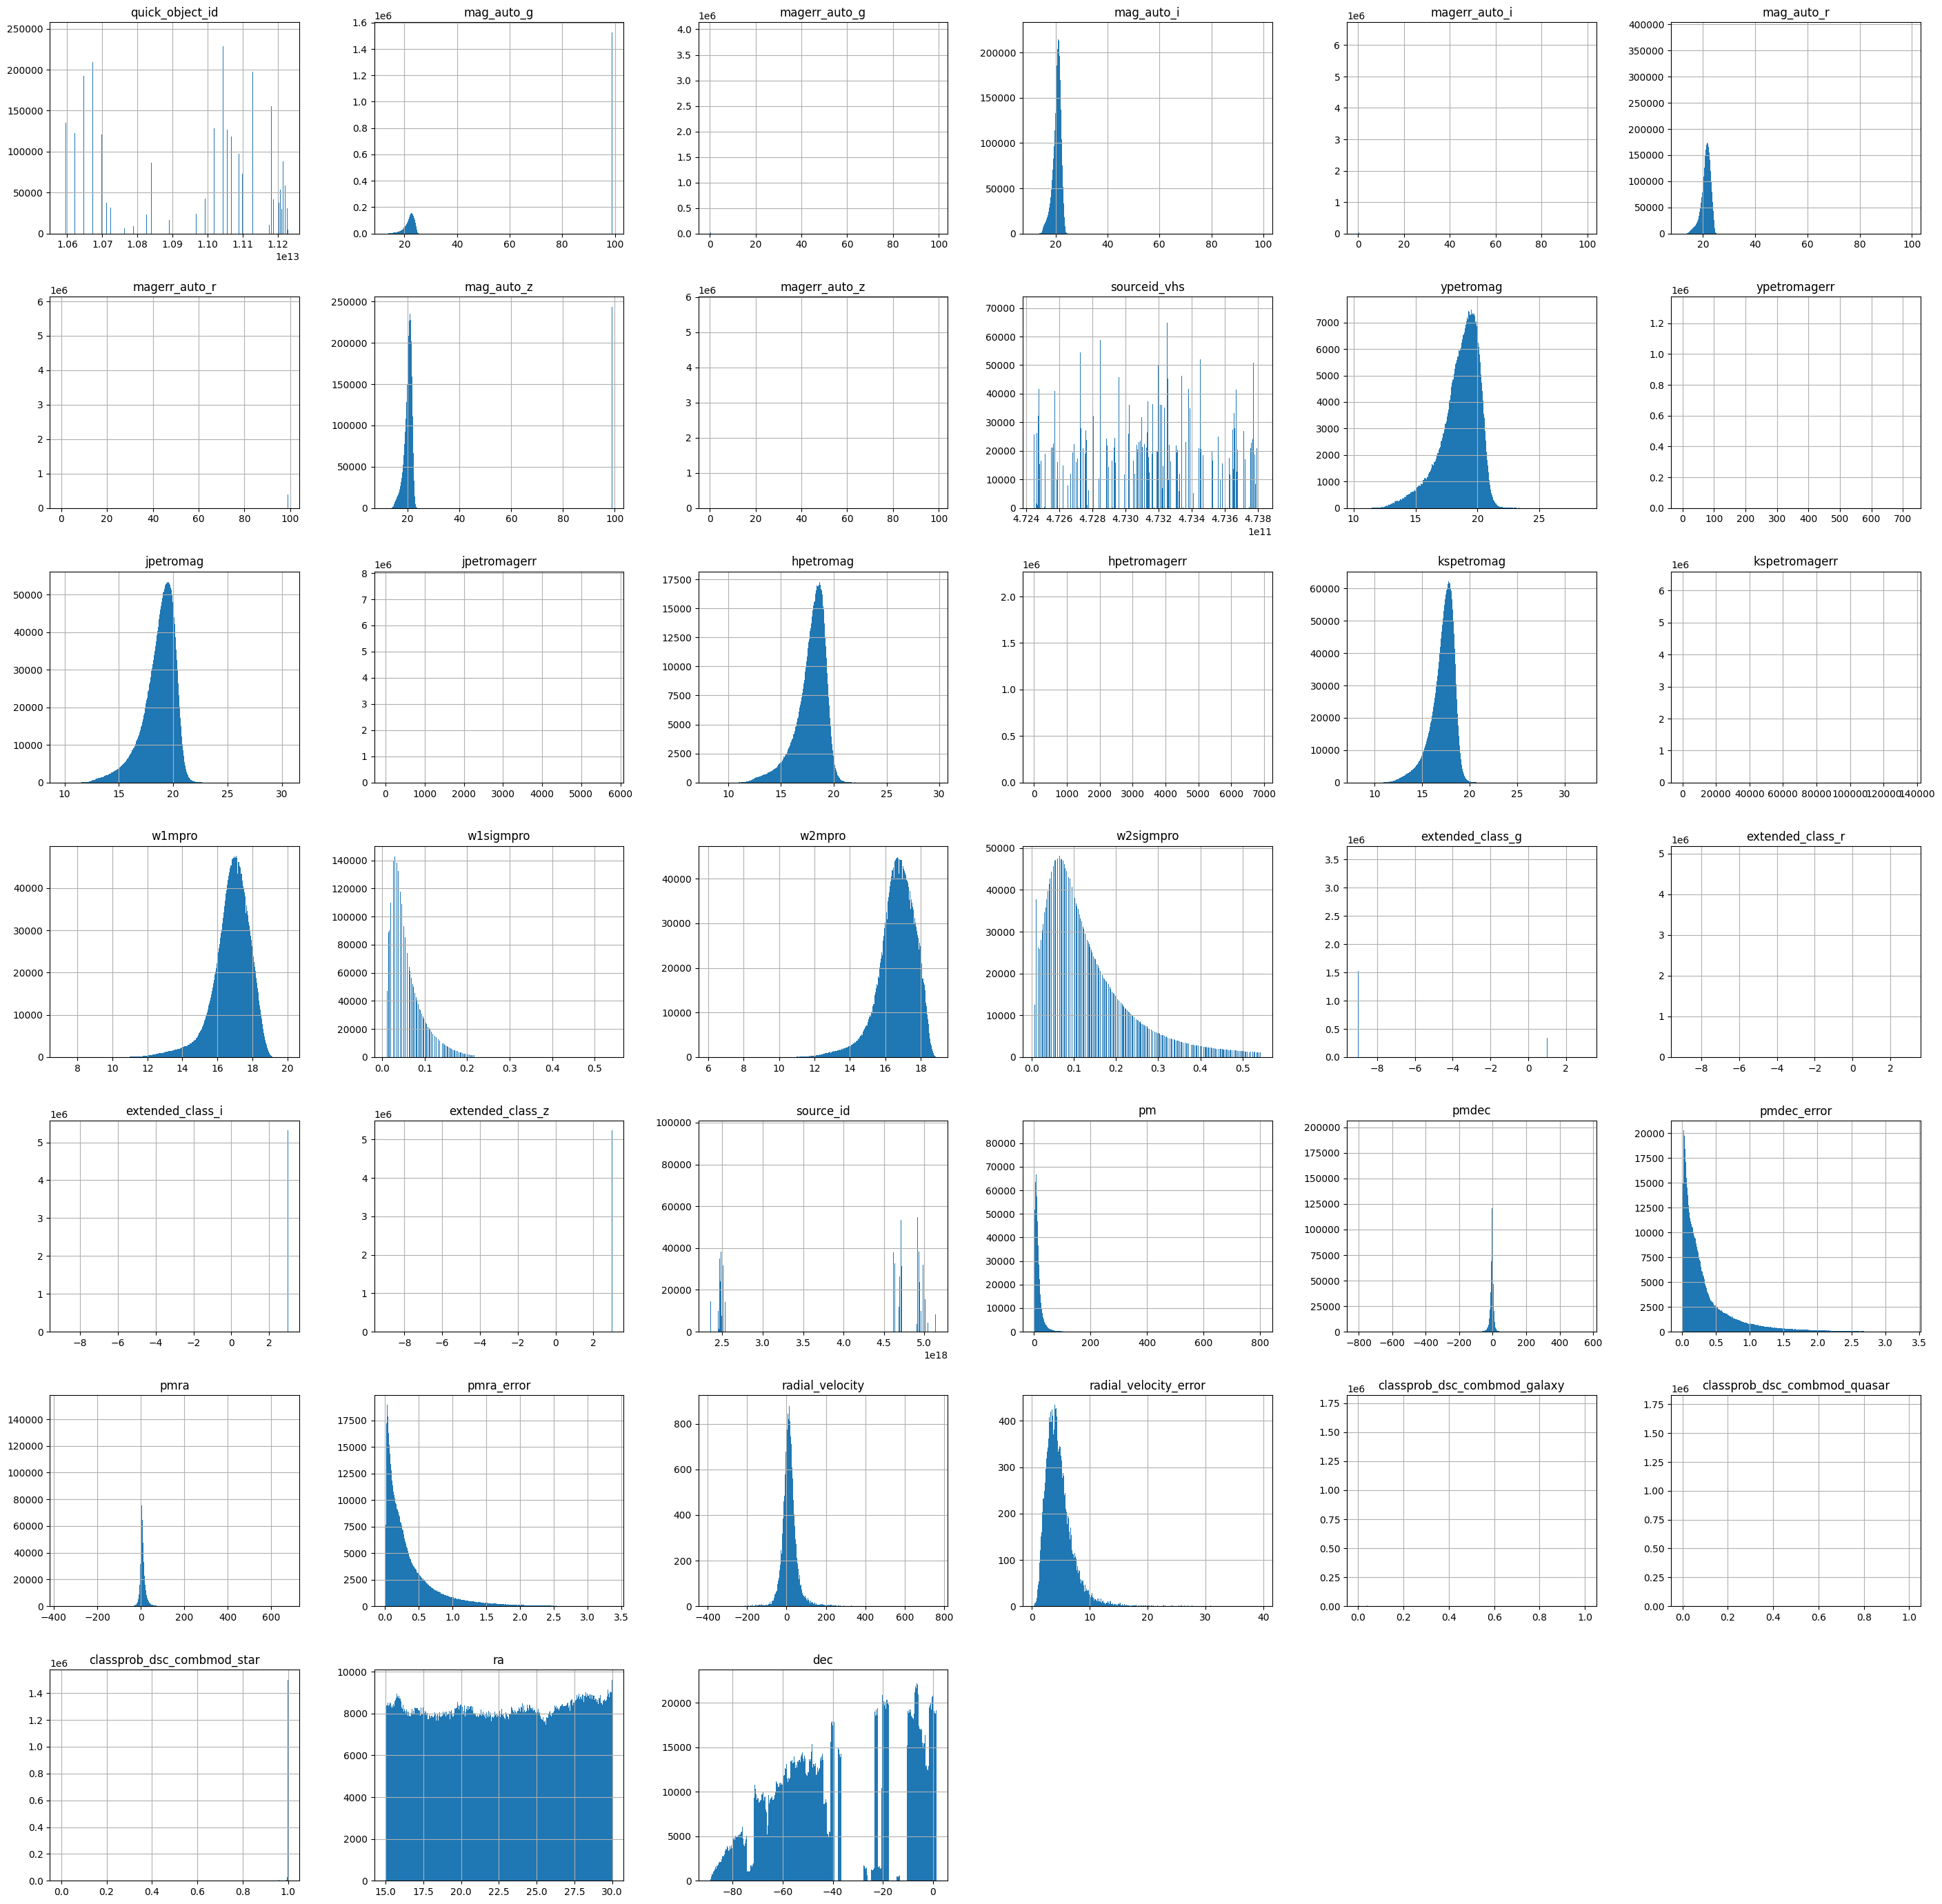

,quick_object_id,mag_auto_g,magerr_auto_g,mag_auto_i,magerr_auto_i,mag_auto_r,magerr_auto_r,mag_auto_z,magerr_auto_z,sourceid_vhs,...,pmdec_error,pmra,pmra_error,radial_velocity,radial_velocity_error,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_quasar,classprob_dsc_combmod_star,ra,dec
count,8.226904e+06,8.226904e+06,8.226904e+06,8.226904e+06,8.226904e+06,8.226904e+06,8.226904e+06,8.226904e+06,8.226904e+06,8.226904e+06,...,1.557373e+06,1.557373e+06,1.557373e+06,48494.000000,48494.000000,1.854957e+06,1.854957e+06,1.854957e+06,8.226891e+06,8.226891e+06
mean,1.094707e+13,3.621252e+01,1.845444e+01,2.265878e+01,2.736921e+00,2.480181e+01,4.699648e+00,2.248277e+01,3.002990e+00,4.731214e+11,...,3.624982e-01,8.006602e+00,3.695771e-01,15.065438,4.757164,3.015133e-02,2.166022e-02,9.447181e-01,2.257660e+01,-3.738723e+01
std,2.121984e+11,3.001855e+01,3.844732e+01,1.282219e+01,1.604855e+01,1.652845e+01,2.089137e+01,1.344820e+01,1.677004e+01,3.948849e+08,...,4.265254e-01,1.473784e+01,4.162963e-01,42.134888,2.530426,1.683584e-01,1.381415e-01,2.224325e-01,4.381642e+00,2.560200e+01
min,1.058290e+13,1.278190e+01,2.510000e-04,1.167814e+01,2.240000e-04,1.210906e+01,2.070000e-04,1.139630e+01,3.180000e-04,4.724485e+11,...,7.023000e-03,-3.656444e+02,7.576000e-03,-389.880100,0.368064,0.000000e+00,0.000000e+00,0.000000e+00,1.500000e+01,-8.917520e+01
25%,1.071090e+13,2.137134e+01,3.564700e-02,1.974994e+01,1.752300e-02,2.029234e+01,1.776200e-02,1.943825e+01,2.461600e-02,4.727721e+11,...,8.902700e-02,8.808007e-01,9.561100e-02,-5.499497,3.120050,0.000000e+00,0.000000e+00,9.995270e-01,1.877783e+01,-5.802477e+01
50%,1.103110e+13,2.271964e+01,1.067540e-01,2.084213e+01,4.437600e-02,2.150048e+01,4.755800e-02,2.049579e+01,6.098700e-02,4.731158e+11,...,2.110240e-01,5.454478e+00,2.270870e-01,12.312459,4.293459,0.000000e+00,0.000000e+00,9.999640e-01,2.261313e+01,-4.380240e+01
75%,1.112821e+13,2.406641e+01,2.546230e-01,2.170479e+01,9.042500e-02,2.257661e+01,1.152750e-01,2.128124e+01,1.132440e-01,4.734579e+11,...,4.546690e-01,1.218151e+01,4.782410e-01,31.317938,5.783195,0.000000e+00,0.000000e+00,9.999900e-01,2.643880e+01,-8.987319e+00
max,1.122840e+13,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,4.738183e+11,...,3.353055e+00,6.766674e+02,3.366169e+00,761.085100,39.556290,1.000000e+00,1.000000e+00,1.000000e+00,3.000000e+01,1.441188e+00


(8226904, 40)

In [5]:
# plot basic histograms of the attributes
fc15_30.hist(figsize = [35, 35], bins=1000)
plt.show()
# display descriptive statistics and the no. of rows and columns
display(fc15_30.describe())
display(fc15_30.shape)

### 3. Data Processing

Create a subset with the maximal number of objects where the data values are meaningful.

In [10]:
# Cut RA, Dec, and Object IDs
# Cut the errors
# Also cut the classprob values
fc_list = ['mag_auto_g', 'mag_auto_i', 'mag_auto_r', 'mag_auto_z', 'ypetromag', 'jpetromag', 'hpetromag',
               'kspetromag', 'w1mpro', 'w1sigmpro', 'w2mpro', 'w2sigmpro', 'extended_class_g', 'extended_class_r', 
               'extended_class_i', 'extended_class_z', 'pm', 'pmdec', 'pmra', 'radial_velocity']

In [12]:
fc15_30 = fc15_30[fc_list]
fc15_30.count()

mag_auto_g          8226904
mag_auto_i          8226904
mag_auto_r          8226904
mag_auto_z          8226904
ypetromag           1312523
jpetromag           7681616
hpetromag           2162878
kspetromag          6286130
w1mpro              8226904
w1sigmpro           8226856
w2mpro              8226904
w2sigmpro           7767672
extended_class_g    8226904
extended_class_r    8226904
extended_class_i    8226904
extended_class_z    8226904
pm                  1557373
pmdec               1557373
pmra                1557373
radial_velocity       48494
dtype: int64

In [15]:
fc15_30 = fc15_30.dropna()
display(fc15_30.describe())
display(fc15_30.shape)
fc15_30.count()

,mag_auto_g,mag_auto_i,mag_auto_r,mag_auto_z,ypetromag,jpetromag,hpetromag,kspetromag,w1mpro,w1sigmpro,w2mpro,w2sigmpro,extended_class_g,extended_class_r,extended_class_i,extended_class_z,pm,pmdec,pmra,radial_velocity
count,3878.000000,3878.000000,3878.000000,3878.000000,3878.000000,3878.000000,3878.000000,3878.000000,3878.000000,3878.000000,3878.000000,3878.000000,3878.000000,3878.000000,3878.000000,3878.000000,3878.000000,3878.000000,3878.000000,3878.000000
mean,15.074490,98.106126,80.541600,92.838422,13.127619,12.830717,12.466560,12.330945,12.222189,0.013240,12.255956,0.009986,0.011088,-7.018824,-8.901238,-8.335740,26.224141,-10.997442,11.025977,0.846028
std,2.050147,8.648432,34.817644,22.005637,0.480781,0.478690,0.503524,0.575930,0.634424,0.002189,0.659612,0.002220,0.293741,3.739231,0.960286,2.377505,31.937372,22.858178,30.705113,38.378949
min,13.586863,13.888441,13.949226,13.643000,10.535904,10.514173,10.439587,9.902435,8.483000,0.011000,8.366000,0.007000,-9.000000,-9.000000,-9.000000,-9.000000,0.240833,-290.918027,-225.113084,-384.349550
25%,14.493887,99.000000,99.000000,99.000000,12.857927,12.559476,12.171757,12.005545,11.890250,0.012000,11.918250,0.009000,0.000000,-9.000000,-9.000000,-9.000000,9.880825,-16.326417,-1.763480,-16.231873
50%,14.873382,99.000000,99.000000,99.000000,13.215891,12.910459,12.528939,12.414473,12.329000,0.013000,12.380000,0.010000,0.000000,-9.000000,-9.000000,-9.000000,17.674724,-7.371130,6.420270,2.919407
75%,15.402130,99.000000,99.000000,99.000000,13.489128,13.185145,12.831912,12.753021,12.678750,0.014000,12.729000,0.010000,0.000000,-9.000000,-9.000000,-9.000000,30.157518,-1.259276,18.508044,21.052890
max,99.000000,99.000000,99.000000,99.000000,14.367229,13.792408,13.527734,13.606899,13.413000,0.058000,13.463000,0.057000,3.000000,3.000000,3.000000,3.000000,421.889700,132.925068,394.791703,234.312870


(3878, 20)

mag_auto_g          3878
mag_auto_i          3878
mag_auto_r          3878
mag_auto_z          3878
ypetromag           3878
jpetromag           3878
hpetromag           3878
kspetromag          3878
w1mpro              3878
w1sigmpro           3878
w2mpro              3878
w2sigmpro           3878
extended_class_g    3878
extended_class_r    3878
extended_class_i    3878
extended_class_z    3878
pm                  3878
pmdec               3878
pmra                3878
radial_velocity     3878
dtype: int64

In [16]:
#Standardizing and Scaling
'''
Standardize to find mean and sigma
Scale the validation sets
Scale the data accordingly as per the classifier
'''

X = fc15_30

X_train, X_test = model_selection.train_test_split(X,test_size = 0.3, random_state = 123)
X_test, X_val = model_selection.train_test_split(X_test, test_size = 0.66, 
                                                                random_state = 123)


scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


#pd.DataFrame(X_test, columns=X.columns).hist(figsize = [35, 35], bins=500)
#plt.show()
display(X_train.shape, X_val.shape, X_test.shape)

(2714, 20)

(769, 20)

(395, 20)

### 4. Model Definition

Model Architecture

In [ ]:
'''
Train a variational autoencoder and add embedding after the first trial
Train on unsupervised data without labels

OR

Better to go via semi-supervised route:
Train classifier RFs on Magnitudes, extendedness, proper motion on similar lsst data
Then use the attributes for this case

Plot latent space tsne
Xgb on latent features
'''

### 5. Model Training

Training Loop